# Local field generated by current clamp in an active neuron model

Adapted from https://github.com/LFPy/LFPy/blob/master/examples/LFPy-example-04.ipynb

Modified by  Darshan Mandge, Open Brain Institute

Copyright (c) 2025 Open Brain Institute

### Downloading the emodel data 

-  The emodel data required to run this notebook (hoc file, morphology file and mechanisms) can be downloaded from the [Blue Brain Open Data](https://registry.opendata.aws/bluebrain_opendata/). In future, you will be able to download the emodel data for different e-models directly from the Open Brain Platform.

    - If using locally on a PC, install [AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-welcome.html) based on [instructions](https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html) for your operating system if you are running locally on your PC.

    - run the following commands


In [1]:
# check if the directory exists if not create it
!if [ ! -d "cadpyr_emodel" ]; then mkdir cadpyr_emodel; fi 

# download mechanisms (mod files)
!aws s3 sync --no-sign-request s3://openbluebrain/Model_Data/Electrophysiological_models/SSCx/OBP_SSCx/emodels/detailed/cADpyr/mechanisms ./cadpyr_emodel/mechanisms 

# hoc file
!aws s3 cp --no-sign-request s3://openbluebrain/Model_Data/Electrophysiological_models/SSCx/OBP_SSCx/emodels/detailed/cADpyr/model.hoc ./cadpyr_emodel/model.hoc

# morphology file 
!aws s3 cp --no-sign-request s3://openbluebrain/Model_Data/Electrophysiological_models/SSCx/OBP_SSCx/emodels/detailed/cADpyr/C060114A5.asc ./cadpyr_emodel/C060114A5.asc

download: s3://openbluebrain/Model_Data/Electrophysiological_models/SSCx/OBP_SSCx/emodels/detailed/cADpyr/model.hoc to cadpyr_emodel/model.hoc
download: s3://openbluebrain/Model_Data/Electrophysiological_models/SSCx/OBP_SSCx/emodels/detailed/cADpyr/C060114A5.asc to cadpyr_emodel/C060114A5.asc


The downloaded folder with data is `./cadpyr_emodel`.

- You can also download the morphology from the platform:

    - Go to https://www.openbraininstitute.org/ `-->` Your virtual lab `-->` Explore `-->` Morphology (bottom of the page) `-->` in the searchbar, search for `C060114A5.asc` `-->` click on the morphology with species `Rattus norvegicus` `-->` Download (top of the page). 
    This will download a zip file with morphology asc file. Extract the zip file and put the `C060114A5.asc` file in the `cadpyr_emodel` folder.

Please update the `venv_path` variable with the path to your python virtual environment.

In [ ]:
# if you don't have the venv path try the last comment 
# try by replacing >> {venv_path}/bin/nrnivmodl << with >> nrnivmodl << in the commands below

venv_path="../../../../.venv/"
emodel_path="./cadpyr_emodel"
# If your emodel path has spaces either replace them  with _ and then run the command.
# Also check, the following line in the notebook, to ensure the correct path is set.
# cell = LFPy.TemplateCell(morphology  = f'{emodel_path}/C060114A5.asc',  ....

# compile mechanisms 
!'{venv_path}bin/nrnivmodl' {emodel_path}/mechanisms

# Alternatively 
# import os
# os.system(f"{venv_path}/bin/nrnivmodl {emodel_folder_path}/mechanisms")

Replace below the path 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import LFPy

--No graphics will be displayed.


In [3]:
# Generate the grid in xz-plane over which we calculate local field potentials
X, Y, Z = np.mgrid[-4:5:1, 1:2, -4:5:1] * 20
# define parameters for extracellular recording electrode, using optional method
electrodeParameters = {
    'sigma' : 0.3,          # extracellular conductivity
    'x' : X.flatten(),      # x,y,z-coordinates of contacts
    'y' : Y.flatten(),
    'z' : Z.flatten(),
    'method' : 'root_as_point',  #sphere source soma segment
    'N' : np.array([[0, 1, 0]]*X.size), #surface normals
    'r' : 2.5,              # contact site radius
    'n' : 20,               # datapoints for averaging
}

In [4]:
# delete old sections from NEURON namespace
LFPy.cell.neuron.h("forall delete_section()")

###NOTE: 
# The hoc template files from bbp couldn't directly be loaded to LFPy using LFPy.TemplateCell. I had to 
# change L153 of LFPy/templatecell.py of my LFPy installation to this to make it work:
# self.template = getattr(neuron.h, self.templatename)(*self.templateargs)

# Initialize cell instance, using the LFPy.TemplateCell not LFPy.Cell class
cell = LFPy.TemplateCell(morphology  = f'{emodel_path}/C060114A5.asc',  # update the morphology file
                templatefile = f'{emodel_path}/model.hoc',              # template file from the emodel folder
                templatename = 'cADpyr_bin_4',                          # name of the template within templatefile. See the line starting with "begintemplate"
                templateargs = [0, emodel_path, 'C060114A5.asc'],
                #  custom_code=['cadpyr/model.hoc'],
                passive      = False,
                nsegs_method = None,
                dt = 2**-6,
                tstart = -159,
                tstop = 6,
                v_init = -60,
                celsius= 34,
                pt3d = True,
               )

# cell = LFPy.Cell(morphology='cadpyr/C060114A5.asc', 
#                  custom_code=['cadpyr/model.hoc'],
#                 dt = 2**-6,
#                 tstart = -159,
#                 tstop = 20,
#                 v_init = -60,
#                 celsius= 34,
#                 pt3d = True,
#                 passive=False)

cell.set_rotation(x=4.729, y=-3.166)
# cell.set_rotation(x=4.98919, y=9.3, z=0)

# create extracellular electrode object for LFPs on grid
electrode = LFPy.RecExtElectrode(cell=cell, **electrodeParameters)

# # https://github.com/LFPy/LFPy/blob/master/examples/example_loadL5bPCmodelsEH.py
PointProcParams = {
    'idx': 0,
    'record_current': False,
    'pptype': 'IClamp',
    'amp': 2.0,
    'dur': 1,
    'delay': 1,
}

# create a current clamp point process at the soma
# https://github.com/LFPy/LFPy/blob/e1a9da2eee6f5e4a0371bceffc7634704feabb68/LFPy/pointprocess.py#L224

pointProcess = LFPy.StimIntElectrode(cell, **PointProcParams)

# perform NEURON simulation
# Simulated results saved as attribute `data` in the RecExtElectrode instance
cell.simulate(probes=[electrode])

In [5]:
def plotstuff(cell, electrode):
    '''plotting'''
    fig = plt.figure(dpi=160)
    
    ax1 = fig.add_axes([0.05, 0.1, 0.55, 0.9], frameon=False)
    cax = fig.add_axes([0.05, 0.115, 0.55, 0.015])
    
    ax1.plot(electrode.x, electrode.z, 'o', markersize=1, color='k',
             zorder=0)
    
    #normalize to min peak
    LFPmin = electrode.data.min(axis=1)
    LFPnorm = -(electrode.data.T / LFPmin).T

    #normalize to max peak instead
    LFPmax = electrode.data.max(axis=1)
    LFPnorm = -(electrode.data.T / LFPmax).T
    
    i = 0
    zips = []
    for x in LFPnorm:
        zips.append(list(zip(cell.tvec*1.6 + electrode.x[i] + 2,
                        x*12 + electrode.z[i])))
        i += 1
    
    line_segments = LineCollection(zips,
                                    linewidths = (1),
                                    linestyles = 'solid',
                                    cmap='nipy_spectral',
                                    zorder=1,
                                    rasterized=False)
    # line_segments.set_array(np.log10(-LFPmin))
    line_segments.set_array(np.log10(LFPmax))

    ax1.add_collection(line_segments)
    
    axcb = fig.colorbar(line_segments, cax=cax, orientation='horizontal')
    axcb.outline.set_visible(False)
    xticklabels = np.array([-0.1  , -0.05 , -0.02 , -0.01 , -0.005, -0.002])
    xticks = np.log10(-xticklabels)
    axcb.set_ticks(xticks)
    axcb.set_ticklabels(np.round(-10**xticks, decimals=3))  
    axcb.set_label('spike amplitude (mV)', va='center')
    
    ax1.plot([22, 38], [100, 100], color='k', lw = 1)
    ax1.text(22, 102, '10 ms')
    
    ax1.plot([60, 80], [100, 100], color='k', lw = 1)
    ax1.text(60, 102, '20 $\\mu$m')
    
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    axis = ax1.axis(ax1.axis('equal'))
    ax1.set_xlim(axis[0]*1.02, axis[1]*1.02)
    
    # plot morphology
    zips = []
    for x, z in cell.get_pt3d_polygons():
        zips.append(list(zip(x, z)))
    from matplotlib.collections import PolyCollection
    polycol = PolyCollection(zips, edgecolors='none',
                             facecolors='gray', zorder=-1, rasterized=False)
    ax1.add_collection(polycol)

    ax1.text(-0.05, 0.95, 'a',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=16, fontweight='demibold',
        transform=ax1.transAxes)
    

    # plot extracellular spike in detail
    ind = np.where(electrode.data == electrode.data.min())[0][0]
    timeind = (cell.tvec >= 0) & (cell.tvec <= 10)
    xticks = np.arange(10)
    xticklabels = xticks
    LFPtrace = electrode.data[ind, ]
    vline0 = cell.tvec[cell.somav==cell.somav.max()]
    vline1 = cell.tvec[LFPtrace == LFPtrace.min()]
    vline2 = cell.tvec[LFPtrace == LFPtrace.max()]
    
    # plot asterix to link trace in (a) and (c)
    ax1.plot(electrode.x[ind], electrode.z[ind], '*', markersize=5, 
             markeredgecolor='none', markerfacecolor='k')
    
    ax2 = fig.add_axes([0.75, 0.6, 0.2, 0.35], frameon=True)
    ax2.plot(cell.tvec[timeind], cell.somav[timeind], lw=1, color='k', clip_on=False)
    
    ax2.vlines(vline0, cell.somav.min(), cell.somav.max(), 'k', 'dashed', lw=0.25)
    ax2.vlines(vline1, cell.somav.min(), cell.somav.max(), 'k', 'dashdot', lw=0.25)
    ax2.vlines(vline2, cell.somav.min(), cell.somav.max(), 'k', 'dotted', lw=0.25)
    
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticks)
    ax2.axis(ax2.axis('tight'))
    ax2.set_ylabel(r'$V_\mathrm{soma}(t)$ (mV)')
    
    for loc, spine in ax2.spines.items():
        if loc in ['right', 'top']:
            spine.set_color('none')            
    ax2.xaxis.set_ticks_position('bottom')
    ax2.yaxis.set_ticks_position('left')
    
    ax2.set_title('somatic potential', va='center')

    ax2.text(-0.3, 1.0, 'b',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=16, fontweight='demibold',
        transform=ax2.transAxes)

    ax3 = fig.add_axes([0.75, 0.1, 0.2, 0.35], frameon=True)
    ax3.plot(cell.tvec[timeind], LFPtrace[timeind], lw=1, color='k', clip_on=False)
    ax3.plot(0.5, 0, '*', markersize=5, markeredgecolor='none', markerfacecolor='k')

    ax3.vlines(vline0, LFPtrace.min(), LFPtrace.max(), 'k', 'dashed', lw=0.25)
    ax3.vlines(vline1, LFPtrace.min(), LFPtrace.max(), 'k', 'dashdot', lw=0.25)
    ax3.vlines(vline2, LFPtrace.min(), LFPtrace.max(), 'k', 'dotted', lw=0.25)

    ax3.set_xticks(xticks)
    ax3.set_xticklabels(xticks)
    ax3.axis(ax3.axis('tight'))
    
    for loc, spine in ax3.spines.items():
        if loc in ['right', 'top']:
            spine.set_color('none')            
    ax3.xaxis.set_ticks_position('bottom')
    ax3.yaxis.set_ticks_position('left')

    ax3.set_xlabel(r'$t$ (ms)', va='center')
    ax3.set_ylabel(r'$\Phi(\mathbf{r},t)$ (mV)')
                   
    ax3.set_title('extracellular spike', va='center')

    ax3.text(-0.3, 1.0, 'c',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=16, fontweight='demibold',
        transform=ax3.transAxes)
    plt.tight_layout()
    return fig

/var/folders/vj/4k3qdfmx21vc8l54r_ck8vr40000gn/T/ipykernel_4908/624550301.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


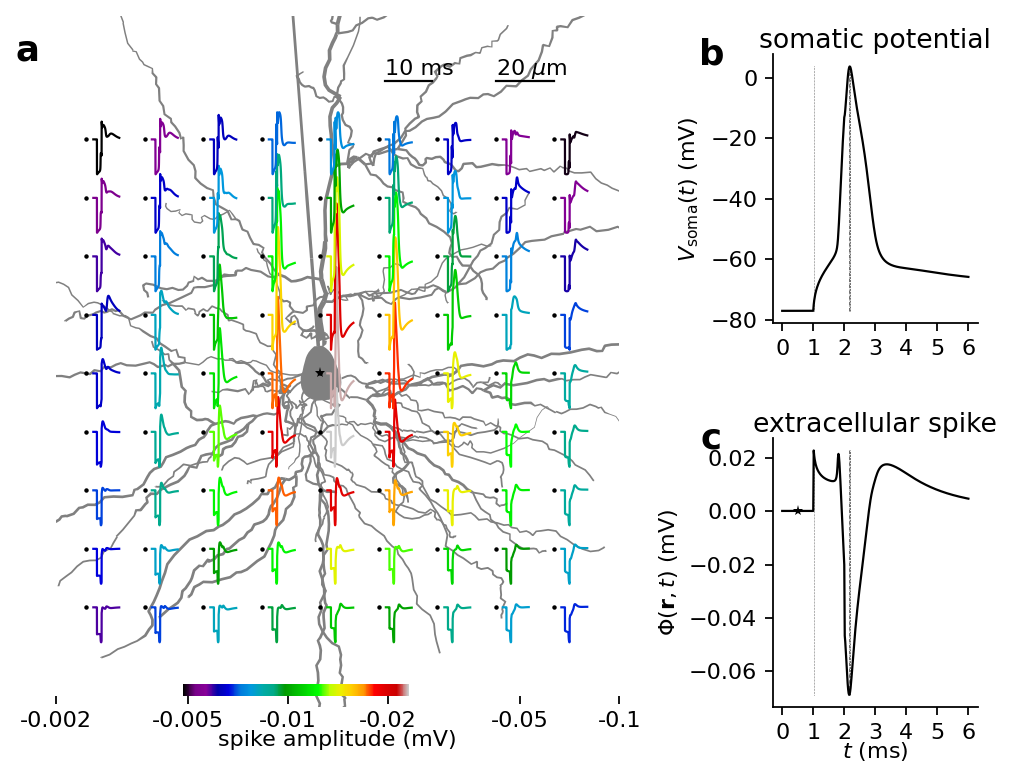

In [6]:
# Plotting of simulation results on MEA grid, somatic potential and extracellular potential
fig = plotstuff(cell, electrode)

# Optional: save image
# fig.savefig('LFPy-example-4.pdf')